In [24]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import spacy

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE

### tqdm
from tqdm import tqdm

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

In [25]:
import os
os.getcwd()

'C:\\Users\\OWNER\\TopicModeling'

In [26]:
# load the data
# ----------

df = pd.read_csv("articles_data.csv")
df_S = df[['Title','Abstract','Full Text']].dropna()
df_S.head()

,Title,Abstract,Full Text
0,The inhibitory impact of collaboration on the ...,The continued influence effect of misinformat...,The continued influence effect of misinformat...
1,RECALL prompting hierarchy improves responsive...,The purpose of the current study was to expand...,The purpose of the current study was to expand...
2,Assessing key soft skills in organizational co...,"Soft skills, also known as transversal skills,...","Introduction: Soft skills, also known as trans..."
3,Mapping perceived sentiments in university cam...,A sustainable university campus should accommo...,A sustainable university campus should accommo...
4,The impact of job stress on job satisfaction a...,The main objective of this study is to explore...,Objective: The main objective of this study is...


In [28]:
# tokenize

###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    # When text is None
    if text is None:
        return []

    # Convert text to lowercase
    text = text.lower()

    # Define additional stop words
    stop_words = STOP_WORDS | {"abstract", "available", "student", "research", "study", "impact", "effect",
                               "result", "al", "et", "doi", "googlescholar", "google", "scholar", "textgoogle", 
                               "full", "crossref", "introduction", "background", "aim", "objective"}

    # Define punctuation
    punc = set(punctuation)

    # Remove punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])

    # Apply NLP processing
    doc = nlp(punc_free)

    # Tokenize and lemmatize
    text_lemma = " ".join([token.lemma_ for token in doc])

    # Filter tokens to remove URLs, stop words, and non-alphabetic tokens
    filtered_tokens = [word for word in text_lemma.split() if word not in stop_words and word.isalpha()]

    # Return filtered tokens for TfidfVectorizer
    return filtered_tokens
    

###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

### sample from the whole dataset
df_S['Title_tokens'] = df_S['Title'].map(lambda x: rem_punc_stop(x))
df_S['Title_join'] = df_S['Title_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")

df_S['Abstract_tokens'] = df_S['Abstract'].map(lambda x: rem_punc_stop(x))
df_S['Abstract_join'] = df_S['Abstract_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


df_S['Full_tokens'] = df_S['Full Text'].map(lambda x: rem_punc_stop(x))
df_S['Full_join'] = df_S['Full_tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


###' ################################################################################
###'
###' Filter Yet Published Papers
###'
###'

df_S['Full_count'] = df_S['Full Text'].dropna().apply(lambda x: len(str(x).split()))
df_S = df_S[df_S['Full_count'] >= 2000]

df_S

,Title,Abstract,Full Text,Title_tokens,Title_join,Abstract_tokens,Abstract_join,Full_tokens,Full_join,Full_count
0,The inhibitory impact of collaboration on the ...,The continued influence effect of misinformat...,The continued influence effect of misinformat...,"[inhibitory, collaboration, continue, influenc...",inhibitory collaboration continue influence mi...,"[continue, influence, misinformation, refer, p...",continue influence misinformation refer persis...,"[continue, influence, misinformation, refer, p...",continue influence misinformation refer persis...,6909
1,RECALL prompting hierarchy improves responsive...,The purpose of the current study was to expand...,The purpose of the current study was to expand...,"[recall, prompt, hierarchy, improve, responsiv...",recall prompt hierarchy improve responsiveness...,"[purpose, current, expand, previous, recall, d...",purpose current expand previous recall dialogi...,"[purpose, current, expand, previous, recall, d...",purpose current expand previous recall dialogi...,6970
2,Assessing key soft skills in organizational co...,"Soft skills, also known as transversal skills,...","Introduction: Soft skills, also known as trans...","[assess, key, soft, skill, organizational, con...",assess key soft skill organizational context d...,"[soft, skill, know, transversal, skill, gain, ...",soft skill know transversal skill gain signifi...,"[soft, skill, know, transversal, skill, gain, ...",soft skill know transversal skill gain signifi...,5729
3,Mapping perceived sentiments in university cam...,A sustainable university campus should accommo...,A sustainable university campus should accommo...,"[mapping, perceive, sentiment, university, cam...",mapping perceive sentiment university campus v...,"[sustainable, university, campus, accommodate,...",sustainable university campus accommodate expe...,"[sustainable, university, campus, accommodate,...",sustainable university campus accommodate expe...,6180
4,The impact of job stress on job satisfaction a...,The main objective of this study is to explore...,Objective: The main objective of this study is...,"[job, stress, job, satisfaction, turnover, int...",job stress job satisfaction turnover intention...,"[main, explore, relationship, job, stress, job...",main explore relationship job stress job satis...,"[main, explore, relationship, job, stress, job...",main explore relationship job stress job satis...,6940
...,...,...,...,...,...,...,...,...,...,...
205,Gaze communicates both cue direction and agent...,Although it is well established that humans sp...,Introduction: Although it is well established ...,"[gaze, communicate, cue, direction, agent, men...",gaze communicate cue direction agent mental state,"[establish, human, spontaneously, attend, look...",establish human spontaneously attend look rema...,"[establish, human, spontaneously, attend, look...",establish human spontaneously attend look rema...,5553
206,The effect of parental and teacher autonomy su...,"According to career construction theory, middl...",Introduction: According to career construction...,"[parental, teacher, autonomy, support, core, s...",parental teacher autonomy support core selfeva...,"[accord, career, construction, theory, middle,...",accord career construction theory middle schoo...,"[accord, career, construction, theory, middle,...",accord career construction theory middle schoo...,5595
207,"Internet addiction, social phobia, substance a...",Internet addiction is a mental health issue th...,Aim: Internet addiction is a mental health iss...,"[internet, addiction, social, phobia, substanc...",internet addiction social phobia substance abu...,"[internet, addiction, mental, health, issue, d...",internet addiction mental health issue detrime...,"[internet, addiction, mental, health, issue, d...",internet addiction mental health issue detrime...,3946
208,Influence of problem-solving ability and perso...,Basketball players are increasingly required n...,Background: Basketball 

# Clustering

In [19]:
dense_matrix

matrix([[0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.70710678, 0.70710678],
        [0.707

In [29]:
X = df_S['Full Text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()
dense_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00262167, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01926746, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [30]:
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(),       # convert to array than to datafram
                        columns=tf.get_feature_names_out())
# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix = columns become documents and rows are words
                     0)  # on column index 0 to show the largest

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
collaboration,0.477442,0.000000,0.005630,0.000000,0.000000,0.000000,0.000000,0.016717,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.006724,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
cie,0.359712,0.000000,0.000000,0.000000,0.000000,0.000000,0.076688,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
ƞ,0.356497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
recall,0.332166,0.168985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006104,0.000000,0.0,0.005177,0.000000,0.000000
memory,0.227371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.004989,0.000000,0.0,0.000000,0.004474,0.000000
free,0.191615,0.000000,0.000000,0.003346,0.000000,0.008195,0.000000,0.000000,0.000000,0.004193,...,0.000000,0.000000,0.000000,0.000000,0.005644,0.000000,0.0,0.000000,0.000000,0.000000
turntaking,0.166937,0.006602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
correction,0.165623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.019027,0.000000,0.000000,0.000000,0.000000,0.0,0.016473,0.000000,0.007659
nominal,0.154342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
condition,0.150727,0.001897,0.005203,0.005241,0.004772,0.000000,0.005185,0.003862,0.013054,0.004378,...,0.048018,0.000000,0.003657,0.001553,0.147310,0.089752,0.0,0.002499,0.005284,0.000000


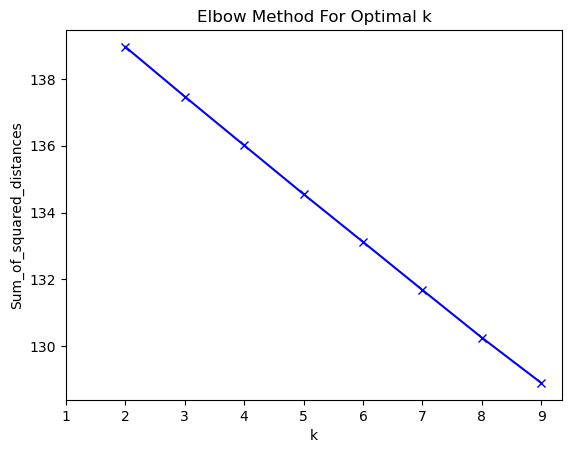

In [32]:
Sum_of_squared_distances = []

K = range(2, 10) 
for k in K:
    km = KMeans(n_clusters=k,     # number of clusters
                init='k-means++', # method for initalization 
                n_init=10)        # number of times the k-means algorithm is run with different centroid seeds
    km = km.fit(tfidf_matrix)     # fit
    Sum_of_squared_distances.append(km.inertia_) # pipe inertia calculations into list


# plot results
# ---------
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xticks(range(1, max(K) + 1, 1))
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [7]:
###' ################################################################################
###'
###' Topic Modeling : Latent Dirichlet Allocation (LDA)
###'
###'


### define function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nlda_{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    

In [15]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
X = df_S['Full Text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning. Is this necessary?

# apply tf-idf vectorizer to our data (X)
tfidf_matrix =  tf.fit_transform(X)

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

# intitialize LDA model and 
# --------
# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5, # specify the number of components
                                max_iter=20,    # specify the number of iterations 
                                random_state=0) # set a seed for reproducibility

# fit LDA model to our dense matrix
lda = lda.fit(np.asarray(dense_matrix))

# post-processing
# --------
# get feature names from our tf-idf vector
tf_feature_names = tf.get_feature_names_out()

# print top words 
print_top_words(lda,               # specify model
                tf_feature_names,  # specify feature names vector
                20)                # specify how many words we want to see
 

# now transform our data using the lda model and create a dataframe
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

# view the corresponding tf-idf dataframe with tf-idf values
topic_dist_df

KeyboardInterrupt: 

In [ ]:
#
# Latent Dirichlet Allocation (LDA)
# ---------------------------------------

# pre-processing
X = df_S['Abstract_join']

tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None) 

tfidf_mx =  tf.fit_transform(X)

dense_matrix = tfidf_mx.todense()


# initialize LDA and set model parameters
lda = LatentDirichletAllocation(n_components=5,
                                max_iter=20,  
                                random_state=0) 

# fit LDA model to our dense matrix
lda = lda.fit(numpy.asarray(dense_matrix))

# post-processing
tf_feature_names = tf.get_feature_names_out()